In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss
from scipy.stats.qmc import Sobol
from scipy.stats import norm

sympy.init_printing()

In [21]:
basis = 'leguerre'

# parameters

mu = 0.06
r = 0.06
T = 1
I = 250
paths = 10
S0 = 40
S0_list = range(37, 43, 1)
m = 0
K = 40

GBM_sigma = 0.04
GBM_mu = r

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

LNparams = (LN_lam, LN_sigma, LN_mu, LN_v, m)
JRparams = (JR_lam, JR_sigma, JR_mu)
GBMparams = (GBM_mu, GBM_sigma)

In [39]:
number_of_samples = I * paths

# Create a Sobol sequence generator
sobol = Sobol(d=1, scramble=True)  # 1-dimensional sequence

# Generate quasi-random numbers in the range [0, 1]
quasi_random_uniform = sobol.random_base2(m=int(np.log2(number_of_samples)))

# Transform the quasi-random numbers to a normal distribution
# Using the Percent Point Function (PPF), which is the inverse of the CDF
quasi_random_normal = norm.ppf(quasi_random_uniform)

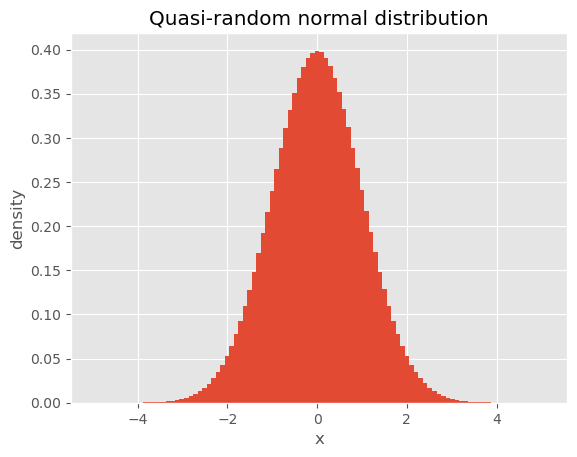

In [40]:
#plot the distribution
fig, ax = plt.subplots()
ax.hist(quasi_random_normal, bins=100, density=True)
ax.set_title('Quasi-random normal distribution')
ax.set_xlabel('x')
ax.set_ylabel('density')
plt.show()


In [24]:
def generate_quasi_random_normal(number_of_samples):
    # Create a Sobol sequence generator
    sobol = Sobol(d=1, scramble=True)  # 1-dimensional sequence

    # Generate quasi-random numbers in the range [0, 1]
    quasi_random_uniform = sobol.random_base2(m=int(np.log2(number_of_samples)))

    # Transform the quasi-random numbers to a normal distribution
    return norm.ppf(quasi_random_uniform)

def gbm_paths_sobol(S0, mu, sigma, T, I, paths, quasi_random_numbers):
    S0, paths, I, T = S0, paths, I, T
    dt = T / I
    matrix = np.zeros((paths, I))
    quasi_random_index = 0  # Index to track the current quasi-random number
    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            Z = quasi_random_numbers[quasi_random_index % len(quasi_random_numbers)]
            quasi_random_index += 1
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

In [25]:
def gbm_paths(S0, mu, sigma, T, I, paths):
    np.random.seed(42)
    S0, paths, I, T = S0, paths, I, T
    dt = T / I
    matrix = np.zeros((paths, I))
    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            Z = np.random.standard_normal()
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

In [26]:
# Total number of quasi-random samples needed
number_of_samples = paths * I

# Generate the quasi-random numbers
quasi_random_numbers = generate_quasi_random_normal(number_of_samples)

In [27]:
# Corrected function call
#quasi_gbm_paths = gbm_paths_sobol(S0, GBM_mu, GBM_sigma, T, I, paths, quasi_random_numbers)

In [28]:
#display_matrix(quasi_gbm_paths)

In [29]:
#plt.figure(figsize=(10, 6))
#plt.plot(quasi_gbm_paths.T, lw=1.5)
#plt.xlabel('time')
#plt.ylabel('index level')
#plt.grid(True)
#plt.show()

In [30]:
def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    np.random.seed(42)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]  # set value at maturity equal to intrinsic value

    # Valuation by LS Method
    for t in range(I - 2, 0, -1):
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive

        if np.sum(good_paths) > 0:
            if basis == 'poly':
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            elif basis == 'legendre':
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            elif basis =='laguerre':
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:  # 'hermite'
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

            exercise = np.zeros(len(good_paths), dtype=bool)
            exercise[good_paths] = H[good_paths, t] > C
        else:
            # If all intrinsic values are zero, mark all as non-exercise
            exercise = np.zeros(len(good_paths), dtype=bool)

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
        discount_path = ~exercise
        V[discount_path, t] = V[discount_path, t + 1] * df

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    variance = np.var(V[:, 1] * df)
    return V0, V0_array, SE, variance

In [31]:
quasi_gbm_paths = gbm_paths_sobol(S0, GBM_mu, GBM_sigma, T, I, paths, quasi_random_numbers)

gbm_paths = gbm_paths(S0, GBM_mu, GBM_sigma, T, I, paths)

In [32]:
V0_quasi, V0_array_quasi, SE_quasi, variance_quasi = LSM(K, quasi_gbm_paths, I, np.exp(-r * T), basis, 2)
V0, V0_array, SE, variance = LSM(K, gbm_paths, I, np.exp(-r * T), basis, 2)

print('Quasi-random numbers')
print('V0: ', V0_quasi.round(5))
print('SE: ', SE_quasi.round(5))
print('Variance: ', variance_quasi.round(5))
print('Random numbers')
print('V0: ', V0.round(5))
print('SE: ', SE.round(5))
print('Variance: ', variance.round(5))

/Users/philipgadereumert/opt/anaconda3/lib/python3.9/site-packages/numpy/polynomial/hermite.py:1403: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermvander, x, y, deg, rcond, full, w)


Quasi-random numbers
V0:  0.06256
SE:  0.00071
Variance:  0.00502
Random numbers
V0:  0.08093
SE:  0.00087
Variance:  0.00748
